In [ ]:
'''
Below is my SABR model implementation that allows the practioner to implement an appropriate volatility smile, essentially saying that 
implied vols across different strikes and tenors are NOT constant as other models assume (namely Black76 and Black Scholes) 


I decided to use the ATM calibration instead of the calibration across all strikes and volatilities as the former is more appropriate for IR
swaptions because, from what I recall and research online, the ATM swaptions are by far the most liquid. Thus, calibrating off the ATM swaptions 
seems most appropriate. 

First, a beta parameter needs to be found/set. This can be done in two ways: either calibrated running simple OLS regression on log(Market IV) vs log(Forward Rates) or simply user selected (between 0 and 1)
Beta is a Shape parameter where 0 = Normal distribution implied (higher vol, typically) ; 1 = lognormal distribution implied (lower vol, typically);

Then I calibrate Rho and Volga. Rho affects the slope of the volatility smile and is a measure of skewness. Therefore, most important parameter 
when pricing risk reversals. A flat skew would thus indicate low rho and sharp tilt indicates high rho. Additionally, in general,
rho becomes negative for longer-dated option maturities.

Volga is the height of the vol smile and is most important when considering the pricing of straddles and strangles. In general, 
volga is higher for short-maturity options and decreases as time-to-maturity increases. 


Then I found the calibrated alpha, which is the core parameter and is based on the other 3, this was found using cubic reduction,
because the function is cubic, there must be at least 1 real positive solution, by definition. Alpha CANNOT be derived from historical data,
root solving needs to be done which is what I do below. 

Then I found the converted Black76 implied vol to be used to find the price of the swaption from the calibrated parameters 

Then I price an example of strikes and market vols with the calibrated parameters to get a BS price.


Notes: I simply made up an example of strikes, Market vols, current underlying rates. I could not find access to different tenure data so I just 
made up example since I don't have access to real-time Bloomberg data. 
'''

In [22]:
import pandas as pd 
import numpy as np
from __future__ import division
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [124]:
def SABRAlphaCalibration(x,F0, ATMVol, tex, beta, rho, volga): 
    '''Function used to calculate the SABR Alpha given market inputs, used in calibration processes given ATM vols
    
    x = Current SABR alpha value 
    F0 = Current forward rate value 
    ATMVol = current value of ATM market vol given F0 
    tex = time to expiry (in years) 
    beta = either calibrated running simple OLS regression on log(Market IV) vs log(Forward Rates) or simply user selected (between 0 and 1) 
    rho = calibrated correaltion coefficient between forward and volatility Wiener processes (Brownian motion; random walk essentially)
    volga = calibrated vol of vol
    
    returns a numerical value that corresponds to the ATM Black-76 equivalent volatility for the given alpha '''
    
    A3 = ((pow((1 - beta),2) ) * tex) / (24 * pow(F0, (2 - 2* beta)))
    A2 =  (rho * volga * beta * tex) / (4 * pow(F0, (1 - beta)))
    A1 = (1 + ((2 - 3 * pow(rho,2)) / 24) *pow(volga, 2)*tex)
    A0 = -ATMVol * pow(F0, (1 - beta))
    return (A3 * pow(x, 3) + A2 * pow(x , 2) + A1 * x + A0)

#example
calibrated_alpha = SABRAlphaCalibration(x = 0.08, F0 = 0.0266, ATMVol = 0.05, tex = 0.25, beta = 0, rho = -0.0356, volga = 1.0504)

In [4]:
def ATMVolToSABRAlpha(F0, ATMVol, tex, beta, rho, volga): 
    ''' 
Returns the ATM SABR Alpha corresponding to the ATM Black market vol, 
using root solving to get the smallest positive root from SABRAlphaCalibration

F0 = Current forward rate value 
ATMVol = current value of ATM market vol given F0 
tex = time to expiry (in years) 
beta = either calibrated running simple OLS regression on log(Market IV) vs log(Forward Rates) or simply user selected (between 0 and 1) 
rho = calibrated correaltion coefficient between forward and volatility Wiener processes (Brownian motion; random walk essentially)
volga = calibrated vol of vol
   
returns single numerical value that is the calibrated SABR ATM alpha 

Because when solving for ATM alpha, SABR reduces to cubic expression and thus, by definition, has a least one real root (positive, in this case) 

    '''
    mins = -100000
    maxs = 100000
    roots = scipy.optimize.brentq(SABRAlphaCalibration, mins, maxs, args = (F0, ATMVol, tex, beta, rho, volga))
   
    return roots


#example
ATMVolToSABRAlpha(F0 = 0.0266, ATMVol = 0.325, tex = 5, beta = .5, rho = -0.3304,volga = .4062)

0.05114876116067733

In [5]:
def SABRtoBlack76(F0, K, tex, Alpha, Beta, Rho, Volga): 
    '''Returns the Black-76 equivalent volatility after calibrating for SABR Alpha, Beta, Rho, and Volga
    F0 = Current forward rate value 
    K = Strike of the swaption
    tex = time to expiry (in years) 
    Alpha = Previously calibrated  implied vol
    
    Beta = Shape parameter; 
    0 = Normal (higher vol, typically) ; 1 = lognormal (lower vol, typically);
    either calibrated running simple OLS regression on log(Market IV) vs log(Forward Rates) or simply user selected (between 0 and 1) 
    
    Rho = calibrated correaltion coefficient between forward and volatility Wiener processes (Brownian motion; random walk essentially)
    Volga = calibrated vol of vol of alpha (calibrated diffusion parameter)
    
    returns Black-76-equivalent volatility that can then be plugged into Black-76 closed-form to derive option price
    
    
    '''
    k1 = pow((F0 * K), ((1 - Beta) / 2))
    k2 = 1 + pow((1 - Beta),2) / 24 * pow((np.log(F0 / K)) ,2) + pow((1 - Beta),4) / 1920 * pow(np.log(F0 / K),4)
    z = Volga / Alpha * pow((F0 * K) , ((1 - Beta) / 2)) * np.log(F0 / K)
    xz = np.log((np.sqrt(1 - 2 * Rho * z + pow(z ,2)) + z - Rho) / (1 - Rho))
    k3 = pow((1 - Beta),2) / 24 * pow(Alpha ,2) / (pow((F0 * K) , ( 1 - Beta)))
    k4 = 1 / 4 * Rho * Beta * Volga * Alpha / ((pow((F0 * K) , ((1 - Beta) / 2))))
    k5 = (2 - 3 * pow(Rho,2)) / 24 * pow(Volga,2)
    
    if(F0 != K):  # if forward rate not equal to strike (not ATM)
        return((Alpha / (k1 * k2)) * (z / xz) * (1 + tex *(k3 + k4 + k5)))

    return((Alpha / (k1 * k2) * 1 * (1 + tex *(k3 + k4 + k5))))



#example
SABRtoBlack76(F0 = 0.0266, K = 0.0266, tex = 0.25, Alpha = 0.0651, Beta = 0.5, Rho = -0.0356,Volga = 1.0504)  

0.40829074633108847

In [189]:
def SABRATMCalibration(F0, ATMVol, Strikes, MarketVols, tex, Beta, guess_rho, guess_volga):
    
    '''Calibrates Rho and Volga such that sum of square errors between Black-76-equivalent SABR vols and market observed vols are minimised.

For a given Rho and Volga, calculates ATM SABR Alpha from this, then calculates the resulting Black-76 vol, then takes SSE.

Minimses SSE function using non-linear optimisation.


F0 = Current forward rate value 
ATMVol = current value of lognormal ATM market vol given F0 
Strikes = vector of market strikes
MarketVols = vector of lognormal market - quoted implied vols
tex = time to expiry (in years) 
Beta = either calibrated running simple OLS regression on log(Market IV) vs log(Forward Rates) or simply user selected (between 0 and 1) 
guess_rho = user-given (between -1 and 1; Cauchy schwartz) correaltion coefficient between forward and volatility Wiener processes (Brownian motion; random walk essentially)
guess_volga = user-given vol of vol (non-zero)

returns list of outputs from the constrained optimization solver that includes the parameters for calibrated Rho/Volga


    '''
    if len(Strikes) != len(MarketVols):
        raise Exception("Strikes vector wrong length")
    if abs(guess_rho) > 1:
        raise Exception("Remember Cauchy_Schwartz Inequality!") 
    if guess_volga <= 0:
        raise Exception("Vol of vol needs to be non zero") 
     
    

    init_params = []
    init_params.append(guess_rho) 
    init_params.append(guess_volga)
    
  
    def SSE(init_params):
        v1 = init_params[0]
        v2 = init_params[1]

    
        ATMAlpha = ATMVolToSABRAlpha(F0, ATMVol, tex, Beta, v1, v2)
        n = len(Strikes)
        CalibVols = []
        for i in range(n):
            CalibVols.append(SABRtoBlack76(F0, Strikes[i], tex, ATMAlpha, Beta, v1, v2))
        
        res = np.sum(np.subtract(CalibVols, MarketVols)**2)
            
        
        return res


   #rho >= -1
   #rho <= 1
   #volga > 0
    bnds = ((-1, 1), (0, np.inf))
    initial_guess = [guess_rho, guess_volga]
    result = scipy.optimize.minimize(SSE, initial_guess, bounds = bnds)
    return result.x

In [190]:
F0 = .0001
ATMVol = 0.4084
Strikes = [10, 20, 30, 40, 50, 60, 100, 150]
MarketVols = [1.047, 0.4812, 0.4327, 0.4268, 0.4148, 0.4253, 0.4322, 0.4495]
tex = .25
Beta = .5 
guess_rho = .05
guess_volga = .5


#example
calibrated_rho = SABRATMCalibration(F0, ATMVol, Strikes, MarketVols, tex, Beta, guess_rho, guess_volga)[0]
calibrated_volga = SABRATMCalibration(F0, ATMVol, Strikes, MarketVols, tex, Beta, guess_rho, guess_volga)[1]

In [ ]:
def SABRVolsFromATMCalib(F0, ATMVol, Strikes, MarketVols, tex, Beta, guess_rho, guess_volga):
        
        ''' 
uses previously coded functions to find the calibrated rho, volga, and alpha for ATM options given some list of strikes and market data 
vols. Then uses these calibrated parameters to find the Black-76 equivalent implied volatility for the different strikes
    
    F0 = Current forward rate value 
    ATMVol = current value of lognormal ATM market vol given F0 
    Strikes = vector of market strikes
    MarketVols = vector of lognormal market - quoted implied vols
    tex = time to expiry (in years) 
    Beta = either calibrated running simple OLS regression on log(Market IV) vs log(Forward Rates) or simply user selected (between 0 and 1) 
    guess_rho = user-given (between -1 and 1; Cauchy schwartz) correaltion coefficient between forward and volatility Wiener processes (Brownian motion; random walk essentially)
    guess_volga = user-given vol of vol (non-zero)
    
returns 
a python dictionary displaying the calibrated SABR model parameters and a vector of input strikes and calibrated the Black-76 equivalent implied volatility for the different strikes
        '''
   
    calibrated = SABRATMCalibration(F0, ATMVol, Strikes, MarketVols, tex, Beta, guess_rho, guess_volga)

   
    calibrated_rho = calibrated[0]
    calibrated_volga = calibrated[1]

 
    calibrated_alpha = ATMVolToSABRAlpha(F0, ATMVol, tex, Beta, calibrated_rho, calibrated_volga)

 
    n = len(Strikes)
    Calib_SABRVols = []
    for i in range(n):
        Calib_SABRVols.append(SABRtoBlack76(F0, Strikes[i], tex, calibrated_alpha, Beta, calibrated_rho, calibrated_volga))
 

 
    results =  pd.DataFrame({"SABR_Alpha": calibrated_alpha, "SABR_Beta": Beta, "SABR_Rho": calibrated_rho, "SABR_Volga": calibrated_volga, "SABR_Strikes": Strikes,
                      "SABR_Vols": Calib_SABRVols})

    return results


   SABR_Alpha  SABR_Beta  SABR_Rho  SABR_Volga  SABR_Strikes  SABR_Vols
0    0.004071        0.5  0.993561    0.995403            10   0.618167
1    0.004071        0.5  0.993561    0.995403            20   0.569699
2    0.004071        0.5  0.993561    0.995403            30   0.542542
3    0.004071        0.5  0.993561    0.995403            40   0.523850
4    0.004071        0.5  0.993561    0.995403            50   0.509692
5    0.004071        0.5  0.993561    0.995403            60   0.498348
6    0.004071        0.5  0.993561    0.995403           100   0.467656
7    0.004071        0.5  0.993561    0.995403           150   0.444449


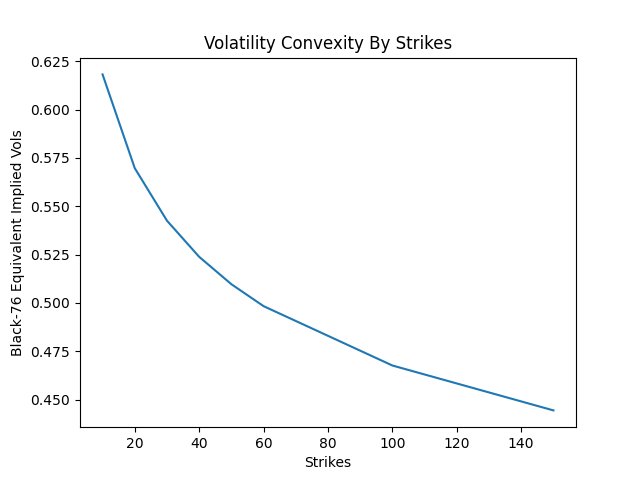

<Figure size 640x480 with 0 Axes>

In [192]:
res = SABRVolsFromATMCalib(F0, ATMVol, Strikes, MarketVols, tex, Beta, guess_rho, guess_volga)
print(res)

plt.plot(res["SABR_Strikes"], res["SABR_Vols"])
 
#set title and x, y - axes labels
plt.title('Volatility Convexity By Strikes')
plt.xlabel('Strikes')
plt.ylabel('Black-76 Equivalent Implied Vols')
 
#show plot to user
plt.show()

In [193]:
from scipy import stats

def BlackOptionPricer(F0, K, Vol, tex, rfr, CallorPut):
    
    ''' Given the Black-76 equivalent volatilities from the calibrated parameters in the SABR model, use these implied vols 
    and various strikes to come up with the BS price of a call or put (payer or receiver swaption, respectively) 
    
    F0= underlying forward rate 
    K = strike price 
    Vol = implied vol from calibrated params 
    tex = time to expiry 
    rfr = risk free rate ~ 10Y 
    CallorPut = Call or Put 
    
    returns singular BS price of option 
    
    ''' 
    
    
    cp = ["c", "p"]
    if CallorPut not in cp:
        raise Exception("Needs to be a Call or Put Option")
    elif CallorPut == "c":
        a = 1
    elif CallorPut == "p":
        a = -1
    
    

    d1 = (np.log(F0 / K) + 0.5 * ( Vol ** 2)  * tex) / (Vol * np.sqrt(tex))
    d2 = d1 - Vol * np.sqrt(tex)

    price = np.exp(-rfr * tex) * a * (F0 * scipy.stats.norm.cdf(a * d1) - K * scipy.stats.norm.cdf(a * d2))

    return price



In [194]:
price = [] 
for i in range(len(res["SABR_Strikes"])):
    price.append(BlackOptionPricer(F0 = 50, K = res["SABR_Strikes"][i], Vol = res["SABR_Vols"][i], tex = tex, rfr = 0.03, CallorPut = 'c'))
res["BlackScholes Price"] = np.round(price,7)


'''For various strikes, find BS price and display''' 
res 

,SABR_Alpha,SABR_Beta,SABR_Rho,SABR_Volga,SABR_Strikes,SABR_Vols,BlackScholes Price
0,0.004071,0.5,0.993561,0.995403,10,0.618167,39.701122
1,0.004071,0.5,0.993561,0.995403,20,0.569699,29.777384
2,0.004071,0.5,0.993561,0.995403,30,0.542542,19.970145
3,0.004071,0.5,0.993561,0.995403,40,0.523850,11.192822
4,0.004071,0.5,0.993561,0.995403,50,0.509692,5.031839
5,0.004071,0.5,0.993561,0.995403,60,0.498348,1.825486
6,0.004071,0.5,0.993561,0.995403,100,0.467656,0.007067
7,0.004071,0.5,0.993561,0.995403,150,0.444449,0.000001


'3d Plot showing Volatility smirk and the corresponding BS price of each individual option '

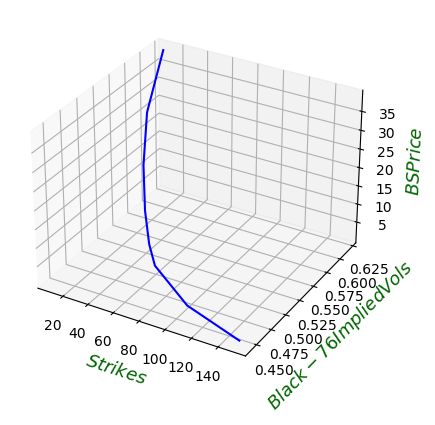

In [195]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
# Data for a three-dimensional line
zline = res["BlackScholes Price"]
xline = res["SABR_Strikes"]
yline = res["SABR_Vols"]
ax.plot3D(xline, yline, zline, 'blue')
ax.set_xlabel('$Strikes$', fontsize=13, color = "darkgreen")
ax.set_ylabel('$Black-76 Implied Vols$', fontsize = 13, color = "darkgreen")
ax.set_zlabel('$BS Price$', fontsize=13, rotation = 0, color = "darkgreen")

'''3d Plot showing Volatility smirk and the corresponding BS price of each individual option ''' 